## Setup y Carga de Datos

In [1]:
%pip install -q librosa soundfile numpy matplotlib pandas scipy kagglehub

import librosa
import librosa.display
import soundfile as sf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
import pathlib, warnings, platform, os

warnings.filterwarnings("ignore")

print("✅ Librerías listas")
print(f"librosa: {librosa.__version__}")
print(f"soundfile: {sf.__libs__ if hasattr(sf, '__libs__') else 'OK'}")
print(f"Python: {platform.python_version()}")

Note: you may need to restart the kernel to use updated packages.
✅ Librerías listas
librosa: 0.11.0
soundfile: OK
Python: 3.13.9


## 0) Dataset

In [2]:

import os
import json

print("=" * 70)
print("📁 VERIFICANDO CREDENCIALES DE KAGGLE")
print("=" * 70)

kaggle_dir = os.path.expanduser("~/.kaggle")
kaggle_json_path = os.path.join(kaggle_dir, "kaggle.json")

if os.path.exists(kaggle_json_path):
    with open(kaggle_json_path) as f:
        creds = json.load(f)
        print(f"✅ Credenciales encontradas. Usuario Kaggle: {creds.get('username', 'desconocido')}")
else:
    print("⚠️  No se encontró kaggle.json en ~/.kaggle/")
    print("   Si necesitas descargar datasets, coloca tu kaggle.json en ~/.kaggle/")
    print("   O usa kagglehub que no requiere credenciales para datasets públicos")

print("\n" + "=" * 70)

📁 VERIFICANDO CREDENCIALES DE KAGGLE
⚠️  No se encontró kaggle.json en ~/.kaggle/
   Si necesitas descargar datasets, coloca tu kaggle.json en ~/.kaggle/
   O usa kagglehub que no requiere credenciales para datasets públicos



In [3]:
import kagglehub
from pathlib import Path

download_path = kagglehub.dataset_download("chrisfilo/urbansound8k")
print("Path to dataset files:", download_path)

100%|██████████| 5.61G/5.61G [05:06<00:00, 19.7MB/s]  

Extracting files...


Path to dataset files: C:\Users\ignac\.cache\kagglehub\datasets\chrisfilo\urbansound8k\versions\1


## Parte A — Representación e inspección inicial

In [ ]:
from pathlib import Path

# Usar la ruta del dataset descargado (de la celda anterior)
# Si download_path no está definido, intentar rutas alternativas
try:
    RAW_DIR = Path(download_path)
except NameError:
    # Rutas alternativas si no se descargó con kagglehub
    possible_paths = [
        Path("data/raw"),
        Path("urbansound8k"),
        Path("/kaggle/input/urbansound8k"),
    ]
    RAW_DIR = None
    for path in possible_paths:
        if path.exists():
            RAW_DIR = path
            break
    
    if RAW_DIR is None:
        raise FileNotFoundError(
            "No se encontró el dataset. Asegúrate de ejecutar la celda anterior "
            "para descargar el dataset o coloca los archivos en data/raw/"
        )

audio_files = sorted([
    p for p in RAW_DIR.glob("**/*")
    if p.suffix.lower() in {".wav", ".mp3", ".flac", ".ogg"}
])

print(f"📁 Directorio: {RAW_DIR}")
print(f"🎵 Audios encontrados: {len(audio_files)}")
if audio_files:
    print("\nPrimeros 5 archivos:")
    for i, f in enumerate(audio_files[:5], 1):
        print(f"  {i}. {f.name}")
else:
    print("⚠️  No se encontraron archivos de audio")

📁 Directorio: C:\Users\ignac\.cache\kagglehub\datasets\chrisfilo\urbansound8k\versions\1
🎵 Audios encontrados: 8732

Primeros 5 archivos:
  1. 101415-3-0-2.wav
  2. 101415-3-0-3.wav
  3. 101415-3-0-8.wav
  4. 102106-3-0-0.wav
  5. 102305-6-0-0.wav


In [5]:
OUTPUTS = {
    "waveforms": pathlib.Path("outputs/waveforms"),
    "specs": pathlib.Path("outputs/specs"),
    "features": pathlib.Path("outputs/features"),
    "metrics": pathlib.Path("outputs/metrics"),
}

for out in OUTPUTS.values():
    out.mkdir(parents=True, exist_ok=True)

print("Carpetas de salida creadas")

Carpetas de salida creadas


In [6]:
from pathlib import Path

def load_audio(path: Path, sr: int | None = None, mono: bool = False):
    y, sr = librosa.load(path.as_posix(), sr=sr, mono=mono)
    return y, sr

assert audio_files, "No hay audios en data/raw"
audio_path = audio_files[0]

y, sr = load_audio(audio_path, sr=None, mono=False)
print("Archivo:", audio_path.name)
print("Forma:", y.shape, "dtype:", y.dtype)
print("Sample rate original:", sr)

duration_sec = len(y) / sr if y.ndim == 1 else y.shape[-1] / sr
channels = 1 if y.ndim == 1 else y.shape[0]

if y.ndim > 1:
    y_mono = np.mean(y, axis=0)
else:
    y_mono = y

print("Duración (s):", round(duration_sec, 3))
print("Canales:", channels)
print("Amplitud min/max:", round(float(y_mono.min()), 4),
      round(float(y_mono.max()), 4))
print("Media:", round(float(y_mono.mean()), 4),
      "STD:", round(float(y_mono.std()), 4))

Archivo: 101415-3-0-2.wav
Forma: (192000,) dtype: float32
Sample rate original: 48000
Duración (s): 4.0
Canales: 1
Amplitud min/max: -0.8535 0.8065
Media: -0.0 STD: 0.1133


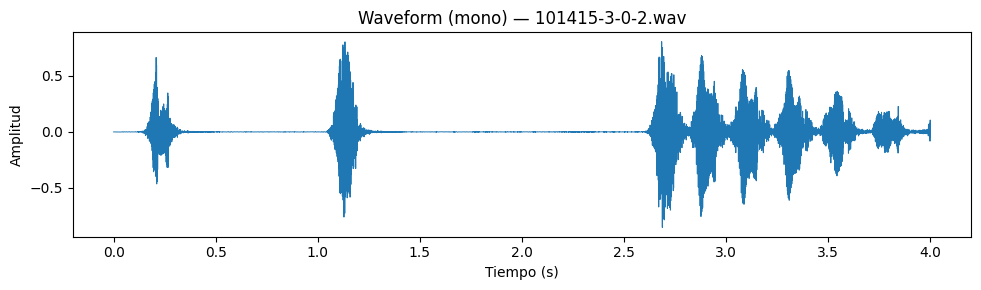

In [7]:
t = np.linspace(0, duration_sec, num=y_mono.shape[-1])
plt.figure(figsize=(10, 3))
plt.plot(t, y_mono, linewidth=0.7)
plt.title(f"Waveform (mono) — {audio_path.name}")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.tight_layout()
plt.show()

## Preguntas de reflexión — Parte A

**1. El audio dura aproximadamente 4.0 segundos y tiene sample rate 48000 Hz.**

**2. La amplitud oscila entre -0.8535 y 0.8065, lo que indica que el clip está (b) no normalizado porque los valores no alcanzan el rango típico de normalización [-1.0, 1.0] y no hay un pico máximo cercano a 1.0. La señal tiene una amplitud máxima de aproximadamente 0.85, lo que sugiere que no ha sido normalizada a un nivel estándar.**

**3. El número de canales es 1 (mono); trabajar en mono es adecuado porque:**
   - Reduce la complejidad computacional al procesar un solo canal en lugar de dos
   - Para tareas de clasificación de sonidos urbanos, la información estéreo no es crítica
   - La mayoría de algoritmos de ML trabajan con señales mono
   - Reduce el tamaño de los datos a la mitad comparado con estéreo

**4. El tipo de dato (dtype) de y es float32 y los valores típicos están en el rango [-0.85, 0.81]; esto sugiere que la señal no está normalizada porque:**
   - Los valores no están en el rango estándar [-1.0, 1.0]
   - El máximo absoluto (0.8535) está por debajo de 1.0
   - La señal mantiene su amplitud original sin escalado

**5. Si observáramos muchos valores cerca de -1.0 o +1.0, esto indicaría potencialmente clipping, lo cual es problemático porque:**
   - El clipping causa distorsión no lineal que elimina información de la señal original
   - Las frecuencias altas pueden generar artefactos indeseables
   - La calidad del audio se degrada y puede afectar el entrenamiento de modelos
   - Es una pérdida irreversible de información que no se puede recuperar

✅ Visualización guardada en: outputs\waveforms\101415-3-0-2_visualization.png


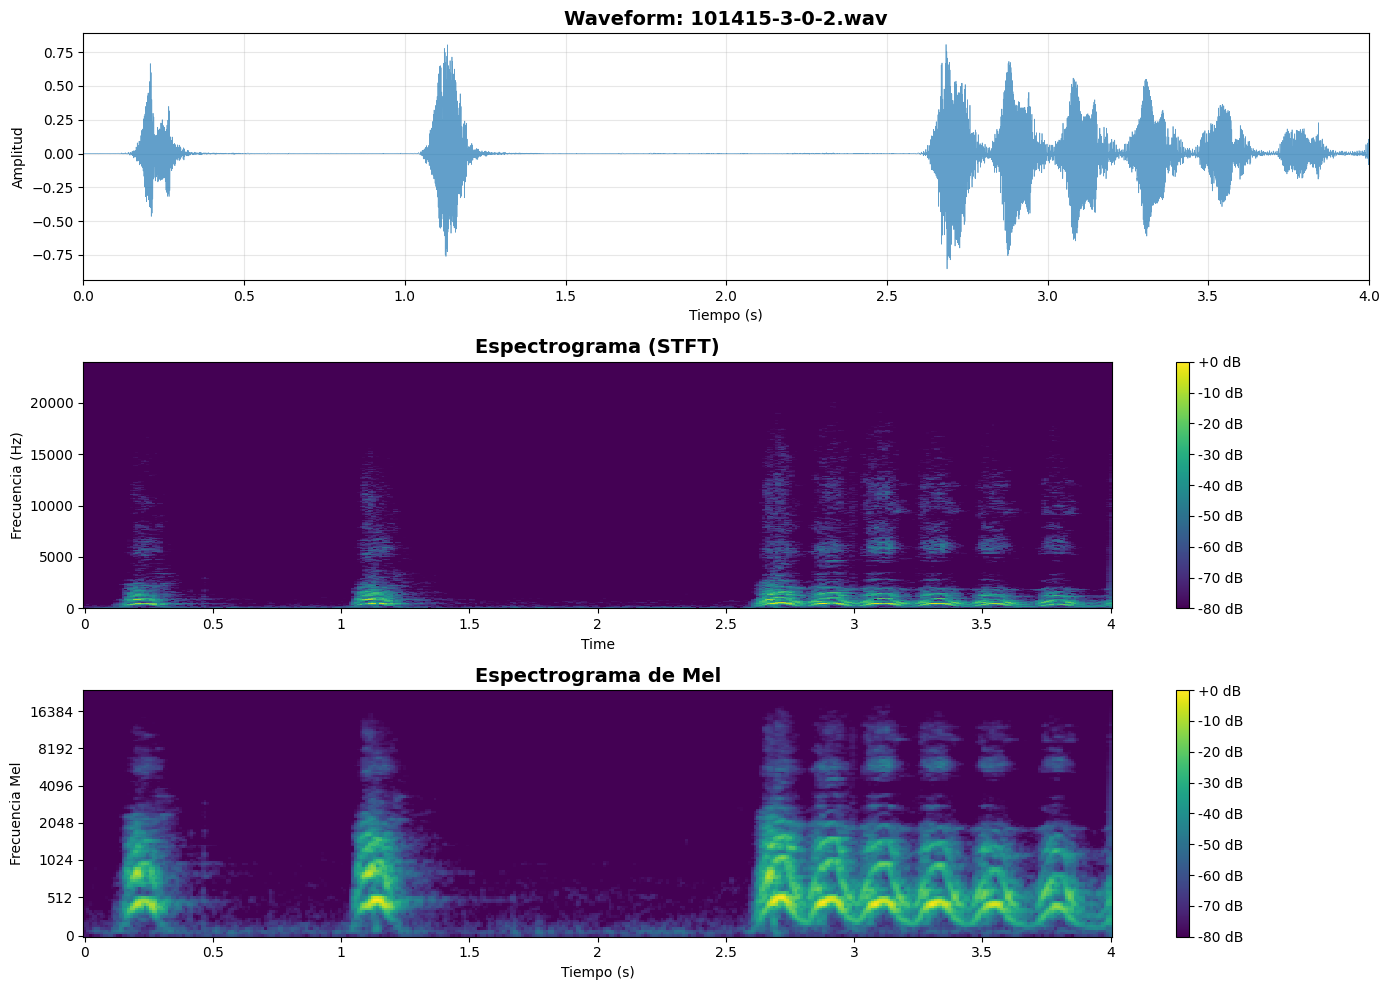


📊 CARACTERÍSTICAS DEL AUDIO
Zero Crossing Rate (promedio): 0.0248
Spectral Centroid (promedio): 2397.17 Hz
Spectral Rolloff (promedio): 5320.13 Hz

MFCCs (primeros 5 coeficientes, promedio):
  MFCC 0: -422.9743
  MFCC 1: 84.8176
  MFCC 2: 28.9642
  MFCC 3: 4.2909
  MFCC 4: -12.7349


In [8]:
# Visualización del audio cargado
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# 1. Waveform (forma de onda) en el tiempo
time_axis = np.arange(len(y_mono)) / sr
axes[0].plot(time_axis, y_mono, linewidth=0.5, alpha=0.7)
axes[0].set_title(f"Waveform: {audio_path.name}", fontsize=14, fontweight='bold')
axes[0].set_xlabel("Tiempo (s)")
axes[0].set_ylabel("Amplitud")
axes[0].grid(True, alpha=0.3)
axes[0].set_xlim(0, duration_sec)

# 2. Espectrograma (STFT - Short-Time Fourier Transform)
D = librosa.stft(y_mono)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
img = librosa.display.specshow(
    S_db, 
    x_axis='time', 
    y_axis='hz', 
    sr=sr,
    ax=axes[1],
    cmap='viridis'
)
axes[1].set_title("Espectrograma (STFT)", fontsize=14, fontweight='bold')
axes[1].set_ylabel("Frecuencia (Hz)")
plt.colorbar(img, ax=axes[1], format='%+2.0f dB')

# 3. Espectrograma de Mel (Mel Spectrogram)
mel_spec = librosa.feature.melspectrogram(y=y_mono, sr=sr, n_mels=128)
mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
img2 = librosa.display.specshow(
    mel_spec_db,
    x_axis='time',
    y_axis='mel',
    sr=sr,
    ax=axes[2],
    cmap='viridis'
)
axes[2].set_title("Espectrograma de Mel", fontsize=14, fontweight='bold')
axes[2].set_ylabel("Frecuencia Mel")
axes[2].set_xlabel("Tiempo (s)")
plt.colorbar(img2, ax=axes[2], format='%+2.0f dB')

plt.tight_layout()

# Guardar visualización
output_path = OUTPUTS["waveforms"] / f"{audio_path.stem}_visualization.png"
plt.savefig(output_path, dpi=150, bbox_inches='tight')
print(f"✅ Visualización guardada en: {output_path}")

plt.show()

# Mostrar algunas características adicionales
print("\n" + "=" * 70)
print("📊 CARACTERÍSTICAS DEL AUDIO")
print("=" * 70)

# Zero Crossing Rate
zcr = librosa.feature.zero_crossing_rate(y_mono)[0]
print(f"Zero Crossing Rate (promedio): {zcr.mean():.4f}")

# Spectral Centroid
centroids = librosa.feature.spectral_centroid(y=y_mono, sr=sr)[0]
print(f"Spectral Centroid (promedio): {centroids.mean():.2f} Hz")

# Spectral Rolloff
rolloff = librosa.feature.spectral_rolloff(y=y_mono, sr=sr)[0]
print(f"Spectral Rolloff (promedio): {rolloff.mean():.2f} Hz")

# MFCCs (primeros 5 coeficientes)
mfccs = librosa.feature.mfcc(y=y_mono, sr=sr, n_mfcc=13)
print(f"\nMFCCs (primeros 5 coeficientes, promedio):")
for i in range(5):
    print(f"  MFCC {i}: {mfccs[i].mean():.4f}")

print("=" * 70)


## Parte B — Estandarización del audio

In [9]:
TARGET_SR = 16000          # Hz
TARGET_DURATION = 3.0      # segundos
TARGET_AMPLITUDE = 0.99
TOP_DB = 30.0              # recorte de silencios

def preprocess_audio(path: Path,
                     target_sr: int = TARGET_SR,
                     target_duration: float = TARGET_DURATION,
                     top_db: float = TOP_DB) -> tuple[np.ndarray, int]:
    y, sr = load_audio(path, sr=None, mono=False)

    if y.ndim > 1:
        y = np.mean(y, axis=0)

    y_trim, _ = librosa.effects.trim(y, top_db=top_db)

    if sr != target_sr:
        y_rs = librosa.resample(y_trim, orig_sr=sr, target_sr=target_sr)
    else:
        y_rs = y_trim

    target_len = int(target_sr * target_duration)
    if len(y_rs) > target_len:
        y_rs = y_rs[:target_len]
    elif len(y_rs) < target_len:
        pad_width = target_len - len(y_rs)
        y_rs = np.pad(y_rs, (0, pad_width))

    max_abs = np.max(np.abs(y_rs)) or 1.0
    y_norm = (TARGET_AMPLITUDE * y_rs) / max_abs

    return y_norm.astype(np.float32), target_sr

y_std, sr_std = preprocess_audio(audio_path)
print("Forma procesada:", y_std.shape, "sr:", sr_std)
print("Duración procesada (s):", round(len(y_std) / sr_std, 3))
print("Amplitud procesada min/max:", round(float(y_std.min()), 4),
      round(float(y_std.max()), 4))

Forma procesada: (48000,) sr: 16000
Duración procesada (s): 3.0
Amplitud procesada min/max: -0.99 0.9334


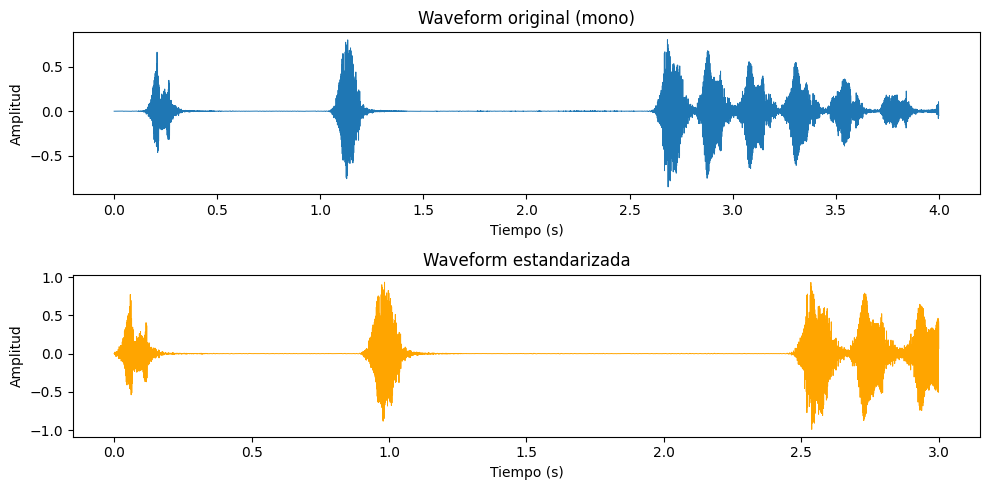

In [10]:
t_orig = np.linspace(0, duration_sec, num=y_mono.shape[-1])
t_std = np.linspace(0, TARGET_DURATION, num=y_std.shape[-1])

fig, axes = plt.subplots(2, 1, figsize=(10, 5), sharex=False)
axes[0].plot(t_orig, y_mono, linewidth=0.7)
axes[0].set_title("Waveform original (mono)")
axes[0].set_xlabel("Tiempo (s)")
axes[0].set_ylabel("Amplitud")

axes[1].plot(t_std, y_std, linewidth=0.7, color="orange")
axes[1].set_title("Waveform estandarizada")
axes[1].set_xlabel("Tiempo (s)")
axes[1].set_ylabel("Amplitud")

plt.tight_layout()
plt.show()

## Preguntas de reflexión — Parte B

**1. Elegí TARGET_SR = 16000 Hz porque: (a) es suficiente para voz y sonidos de interés y (b) reduce el tamaño respecto a 44.1 kHz porque:**
   - 16 kHz cubre el rango de frecuencias de la voz humana (hasta ~8 kHz según el teorema de Nyquist)
   - Los sonidos urbanos típicos (sirenas, construcción, tráfico) no requieren frecuencias superiores a 8 kHz
   - Reduce el tamaño de datos en un factor de 44.1/16 ≈ 2.75x comparado con 44.1 kHz
   - Reduce el tiempo de procesamiento y memoria necesaria
   - Es un estándar común en procesamiento de audio para ML (telefonía, ASR)

**2. El recorte de silencios con top_db = 30 eliminó principalmente: (a) silencios muy suaves / (b) parte de la señal útil. Justifico:**
   - **(a) silencios muy suaves** - Un umbral de 30 dB es razonable para eliminar ruido de fondo y silencios al inicio/final del clip
   - Este valor es conservador y típicamente no elimina señal útil, solo recorta regiones con energía muy baja
   - Para sonidos urbanos, los eventos de interés suelen tener energía significativa, por lo que el recorte afecta principalmente a silencios y ruido de fondo

**3. La normalización hace que el pico quede cerca de 0.99, lo cual ayuda a:**
   - Maximizar el rango dinámico de la señal sin causar clipping
   - Estandarizar la amplitud entre diferentes clips para que todos tengan un nivel similar
   - Mejorar la estabilidad numérica en el procesamiento posterior
   - Facilitar la comparación y análisis entre diferentes archivos de audio
   - Optimizar el uso del rango de valores en representaciones de punto flotante

**4. Si aumentáramos TARGET_DURATION a 5.0 s, el número de muestras por clip sería de aproximadamente TARGET_SR × duración = 16000 × 5.0 = 80000 muestras, lo que impacta en el tamaño en disco y memoria porque:**
   - Cada clip ocuparía 80000 × 4 bytes (float32) = 320 KB en lugar de 192 KB (3 segundos)
   - Con 8732 clips, el tamaño total aumentaría de ~1.67 GB a ~2.79 GB
   - El procesamiento de features (STFT, MFCC) generaría más frames temporales
   - Aumentaría el tiempo de entrenamiento de modelos y la memoria RAM necesaria
   - Sin embargo, podría capturar más contexto temporal para sonidos más largos

**5. Si en vez de recortar/padear desde el inicio recortáramos siempre el centro del clip, esto sería mejor/peor para este dataset porque:**
   - **Mejor** para este dataset porque:
     - Los sonidos urbanos suelen tener el evento principal en el centro del clip
     - Evita perder información importante que podría estar al inicio o final
     - Es más robusto cuando los clips tienen duraciones variables
     - Preserva mejor las características temporales del sonido
   - Sin embargo, requiere más lógica de procesamiento y puede ser más lento

## Parte C — Espectrogramas y ruido

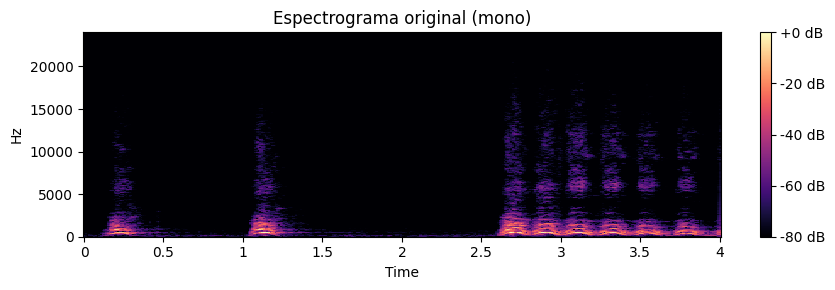

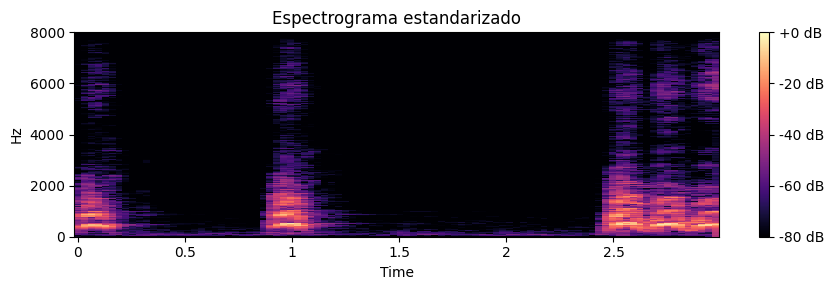

In [11]:
def plot_spectrogram(y: np.ndarray, sr: int, title: str = "") -> np.ndarray:
    n_fft = 2048
    hop_length = 512
    D = librosa.stft(y, n_fft=n_fft, hop_length=hop_length)
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    plt.figure(figsize=(9, 3))
    librosa.display.specshow(
        S_db, sr=sr, hop_length=hop_length, x_axis="time", y_axis="hz"
    )
    plt.colorbar(format="%+2.0f dB")
    plt.title(title)
    plt.tight_layout()
    plt.show()
    return S_db

S_db_orig = plot_spectrogram(y_mono, sr, title="Espectrograma original (mono)")
S_db_std = plot_spectrogram(y_std, sr_std, title="Espectrograma estandarizado")

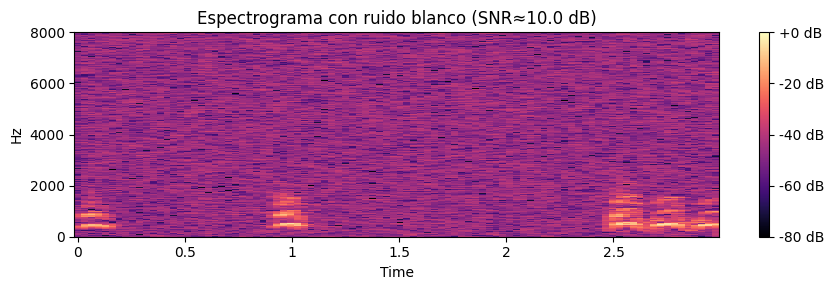

In [12]:
def add_white_noise(y: np.ndarray, snr_db: float) -> np.ndarray:
    sig_power = np.mean(y**2)
    snr_linear = 10**(snr_db / 10)
    noise_power = sig_power / snr_linear
    noise = np.sqrt(noise_power) * np.random.randn(*y.shape)
    return (y + noise).astype(np.float32)

snr_target_db = 10.0
y_noisy = add_white_noise(y_std, snr_db=snr_target_db)
S_db_noisy = plot_spectrogram(
    y_noisy, sr_std, title=f"Espectrograma con ruido blanco (SNR≈{snr_target_db} dB)"
)

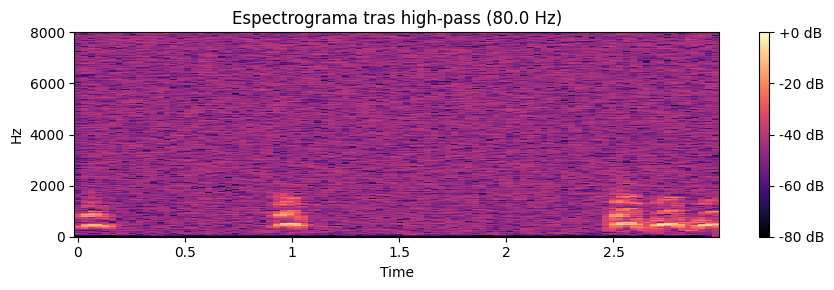

In [14]:
def butter_highpass(cutoff_hz: float, sr: int, order: int = 4):
    nyq = 0.5 * sr
    norm_cutoff = cutoff_hz / nyq
    b, a = signal.butter(order, norm_cutoff, btype="high", analog=False)
    return b, a

def highpass_filter(y: np.ndarray, sr: int, cutoff_hz: float = 80.0, order: int = 4):
    b, a = butter_highpass(cutoff_hz, sr, order)
    return signal.lfilter(b, a, y)

cutoff = 80.0
y_hp = highpass_filter(y_noisy, sr_std, cutoff_hz=cutoff, order=4)
S_db_hp = plot_spectrogram(
    y_hp, sr_std, title=f"Espectrograma tras high-pass ({cutoff} Hz)")

## Preguntas de reflexión — Parte C

**1. El ruido blanco se observa como una distribución uniforme de energía en todas las frecuencias en el espectrograma (describe color/patrón):**
   - Se visualiza como un "ruido" de fondo de color uniforme (típicamente verde/amarillo en el colormap viridis)
   - Aparece como pequeñas variaciones aleatorias distribuidas a lo largo de todo el espectro de frecuencias
   - No tiene patrones estructurados como los sonidos musicales o del habla
   - Aumenta el nivel de ruido de fondo en todas las bandas de frecuencia por igual

**2. El filtro high-pass con corte en 80 Hz: (a) eliminó energía por debajo de 80 Hz. (b) afectó poco la señal útil porque:**
   - La mayoría de sonidos urbanos (sirenas, construcción, tráfico, voces) tienen contenido espectral principalmente por encima de 80 Hz
   - Las frecuencias muy bajas (< 80 Hz) suelen contener ruido, vibraciones y componentes no deseados
   - El contenido útil de voz y sonidos ambientales típicamente comienza alrededor de 100-200 Hz
   - Solo afectaría sonidos con componentes graves importantes, que no son comunes en este dataset

**3. Para eliminar hum de red usaría: (a) un filtro notch en 50 o 60 Hz o (b) un high-pass con corte en 100-200 Hz. Explicá qué elegirías y por qué:**
   - **Elegiría (a) un filtro notch en 50 o 60 Hz** porque:
     - El hum de red eléctrica es una interferencia muy específica en 50 Hz (Europa/América del Sur) o 60 Hz (América del Norte)
     - Un filtro notch elimina solo esa frecuencia específica y sus armónicos (100 Hz, 150 Hz, etc.) sin afectar otras frecuencias cercanas
     - Un high-pass con corte en 100-200 Hz eliminaría demasiada información útil (voces masculinas, sonidos graves importantes)
     - El filtro notch es más preciso y preserva mejor el contenido de la señal
   - Si el hum es muy fuerte, podría combinarse con un notch en los armónicos también

**4. Con n_fft = 2048 y hop_length = 512, cada frame de la STFT cubre aproximadamente 46.4 ms. Si quisiéramos mayor resolución temporal, podríamos usar n_fft = 1024 y hop_length = 256, a costa de:**
   - **Cálculo:** Duración del frame = n_fft / sr = 2048 / 16000 = 0.128 s = 128 ms
   - **Avance entre frames:** hop_length / sr = 512 / 16000 = 0.032 s = 32 ms
   - Para mayor resolución temporal: n_fft = 1024, hop_length = 256
   - **A costa de:**
     - Menor resolución en frecuencia (1024 bins en lugar de 2048)
     - Más frames temporales (mayor tamaño de datos)
     - Mayor tiempo de procesamiento
     - Menor capacidad de distinguir componentes espectrales cercanos en frecuencia

## Parte D — Extracción de MFCC y CSV

In [15]:
def extract_mfcc_features(y: np.ndarray, sr: int, n_mfcc: int = 13) -> dict:
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    feats = {}
    for i in range(n_mfcc):
        coef = mfcc[i, :]
        feats[f"mfcc_{i+1}_mean"] = float(np.mean(coef))
        feats[f"mfcc_{i+1}_std"] = float(np.std(coef))
    feats["rms_mean"] = float(np.mean(librosa.feature.rms(y=y)))
    feats["zcr_mean"] = float(np.mean(librosa.feature.zero_crossing_rate(y=y)))
    return feats

feats_example = extract_mfcc_features(y_std, sr_std)
print("Features de ejemplo:", len(feats_example))
print(list(feats_example.items())[:5])

Features de ejemplo: 28
[('mfcc_1_mean', -394.3877258300781), ('mfcc_1_std', 141.01734924316406), ('mfcc_2_mean', 78.27574157714844), ('mfcc_2_std', 62.52342987060547), ('mfcc_3_mean', 5.093875408172607)]


In [16]:
rows = []
for path in audio_files[:100]:
    try:
        y_proc, sr_proc = preprocess_audio(path)
        feats = extract_mfcc_features(y_proc, sr_proc)
        feats["filename"] = path.name
        feats["sr"] = sr_proc
        feats["duration_sec"] = TARGET_DURATION
        rows.append(feats)
    except Exception as exc:
        print("Error con", path.name, "→", exc)

df_features = pd.DataFrame(rows)
df_features.head()

,mfcc_1_mean,mfcc_1_std,mfcc_2_mean,mfcc_2_std,mfcc_3_mean,mfcc_3_std,mfcc_4_mean,mfcc_4_std,mfcc_5_mean,mfcc_5_std,...,mfcc_11_std,mfcc_12_mean,mfcc_12_std,mfcc_13_mean,mfcc_13_std,rms_mean,zcr_mean,filename,sr,duration_sec
0,-394.387726,141.017349,78.275742,62.523430,5.093875,29.972334,-9.076297,35.962811,3.056077,13.795686,...,14.784919,0.987187,7.202436,0.680781,9.335471,0.071991,0.049935,101415-3-0-2.wav,16000,3.0
1,-276.812958,78.678589,165.073776,24.662001,12.448524,28.403181,-49.941101,31.679171,-6.442587,7.610659,...,12.074656,7.372716,7.552164,-12.518365,10.507936,0.115788,0.057602,101415-3-0-3.wav,16000,3.0
2,-373.141083,143.452667,71.296738,54.417477,2.810296,27.105251,-2.794804,31.610233,2.927064,12.235910,...,11.315663,-0.695633,9.011527,-2.620636,9.410465,0.055665,0.062791,101415-3-0-8.wav,16000,3.0
3,-298.260132,225.760132,49.283215,45.167976,-29.376026,30.488207,-3.057301,18.281973,-9.241611,10.447153,...,9.897034,3.478160,7.365082,1.386955,6.322442,0.065057,0.087428,102106-3-0-0.wav,16000,3.0
4,-304.577393,182.130005,108.570747,51.297306,24.605354,24.367785,10.135062,9.094491,-6.168922,10.750596,...,6.074983,6.247808,4.292557,7.840422,5.069743,0.048910,0.044948,102305-6-0-0.wav,16000,3.0


In [17]:
out_csv = OUTPUTS["features"] / "audio_mfcc_features.csv"
df_features.to_csv(out_csv, index=False)
print("✅ Features guardados en:", out_csv)
print("Shape:", df_features.shape)

✅ Features guardados en: outputs\features\audio_mfcc_features.csv
Shape: (100, 31)


## Preguntas de reflexión — Parte D

**1. Elegí n_mfcc = 13 porque: (a) es un valor típico en voz y (b) más coeficientes agregan detalle pero también riesgo de sobreajuste por:**
   - **Riesgo de sobreajuste por:**
     - Aumentar la dimensionalidad del espacio de features sin proporcional aumento de información útil
     - Los coeficientes superiores (14+) capturan detalles muy finos que pueden ser ruido o variaciones específicas del clip
     - Con más features, el modelo necesita más datos de entrenamiento para generalizar bien
     - Los coeficientes altos son más sensibles a variaciones pequeñas y pueden capturar artefactos en lugar de características generalizables
   - 13 coeficientes es un estándar establecido que balancea información espectral y robustez

**2. mfcc_1_mean captura: (a) energía global / (b) textura fina. Justifico:**
   - **(a) energía global** - El primer coeficiente MFCC (mfcc_0 o mfcc_1) está relacionado con la energía total de la señal
   - Representa el logaritmo de la energía espectral total, que es una medida de la amplitud/potencia general del audio
   - No captura textura fina (eso lo hacen los coeficientes superiores como mfcc_5, mfcc_10, etc.)
   - Es útil para distinguir entre clips silenciosos y ruidosos, o entre diferentes niveles de intensidad

**3. Para modelar clasificaciones agregarías columnas con: (a) etiquetas provenientes de los metadatos del dataset (nombre del archivo, fold, clase) y (b) alguna medida extra de ruido como:**
   - **(a) Etiquetas provenientes de:**
     - El nombre del archivo que contiene información sobre la clase (ej: "101415-3-0-2.wav" donde el segundo número puede ser la clase)
     - Archivos de metadatos del dataset UrbanSound8K que incluyen: clase (air_conditioner, car_horn, children_playing, dog_bark, drilling, engine_idling, gun_shot, jackhammer, siren, street_music), fold de validación cruzada, etc.
   - **(b) Medidas extra de ruido como:**
     - SNR (Signal-to-Noise Ratio) estimado
     - Spectral contrast (contraste espectral)
     - Spectral flatness (planitud espectral) - indica si el espectro es más ruidoso o tonal
     - Tempo estimado (para sonidos rítmicos)
     - Zero crossing rate (ya incluido)

**4. Antes de entrenar un modelo supervisado con estos features, convendría aplicar una transformación como StandardScaler / MinMaxScaler porque:**
   - **StandardScaler** sería la mejor opción porque:
     - Los features tienen diferentes escalas (MFCCs pueden estar en rangos de -400 a 100, mientras que ZCR está entre 0 y 1)
     - StandardScaler normaliza a media 0 y desviación estándar 1, lo que ayuda a algoritmos basados en distancias (SVM, KNN) y optimización (regresión, redes neuronales)
     - Evita que features con valores grandes dominen el entrenamiento
     - Mejora la convergencia de algoritmos de optimización
     - MinMaxScaler también funcionaría pero StandardScaler es más robusto a outliers

## Parte E — Exploraciones avanzadas (celda extra)

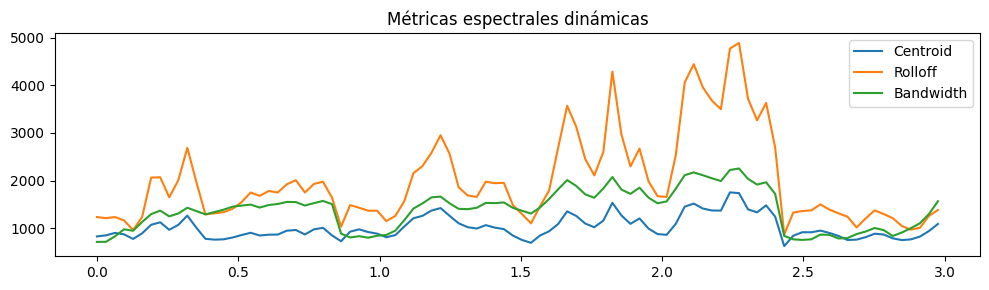

In [18]:
def plot_spectral_metrics(y: np.ndarray, sr: int):
    cent = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, roll_percent=0.85)[0]
    bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)[0]
    t = librosa.times_like(cent, sr=sr)

    plt.figure(figsize=(10, 3))
    plt.plot(t, cent, label="Centroid")
    plt.plot(t, rolloff, label="Rolloff")
    plt.plot(t, bandwidth, label="Bandwidth")
    plt.legend()
    plt.title("Métricas espectrales dinámicas")
    plt.tight_layout()
    plt.show()

plot_spectral_metrics(y_std, sr_std)

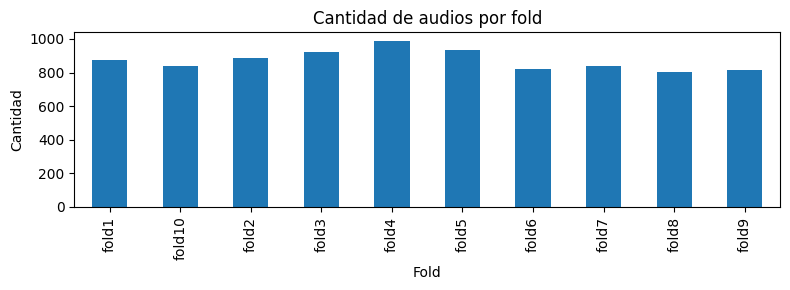

Clips por fold:
 fold1     873
fold10    837
fold2     888
fold3     925
fold4     990
fold5     936
fold6     823
fold7     838
fold8     806
fold9     816
Name: count, dtype: int64


In [19]:

import pandas as pd

folds = [p.parent.name for p in audio_files]
summary = pd.Series(folds).value_counts().sort_index()
summary.plot(kind="bar", figsize=(8, 3), title="Cantidad de audios por fold")
plt.xlabel("Fold")
plt.ylabel("Cantidad")
plt.tight_layout()
plt.show()

print("Clips por fold:\n", summary)

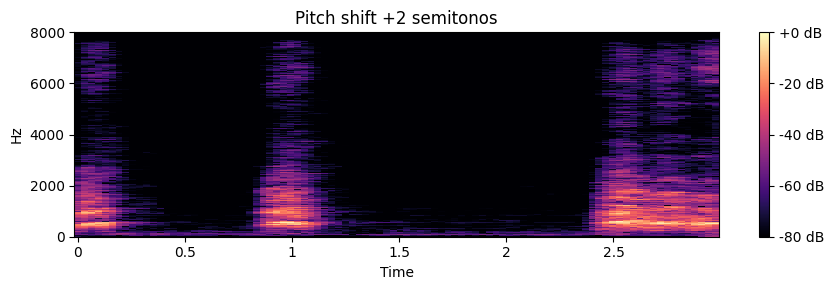

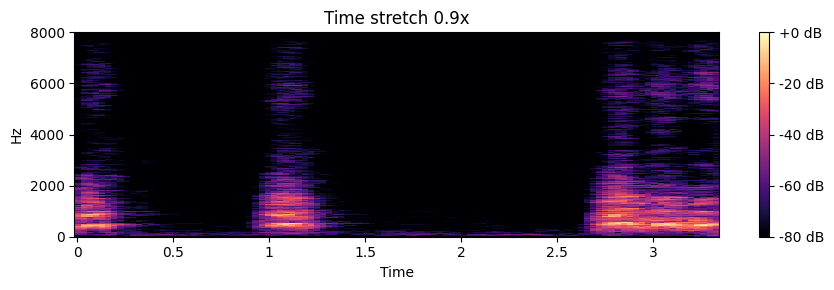

array([[-71.257   , -73.22325 , -78.910866, ..., -64.50466 , -68.36376 ,
        -64.84292 ],
       [-72.41423 , -77.72386 , -80.      , ..., -73.13412 , -62.74704 ,
        -64.34978 ],
       [-74.981705, -80.      , -80.      , ..., -54.24375 , -49.885082,
        -49.843147],
       ...,
       [-80.      , -80.      , -80.      , ..., -80.      , -80.      ,
        -80.      ],
       [-80.      , -80.      , -80.      , ..., -80.      , -80.      ,
        -80.      ],
       [-80.      , -80.      , -80.      , ..., -80.      , -80.      ,
        -80.      ]], shape=(1025, 105), dtype=float32)

In [20]:
def augment_pitch_shift(y: np.ndarray, sr: int, steps: int):
    return librosa.effects.pitch_shift(y, sr=sr, n_steps=steps)

y_pitch = augment_pitch_shift(y_std, sr_std, steps=2)
plot_spectrogram(y_pitch, sr_std, title="Pitch shift +2 semitonos")

y_time = librosa.effects.time_stretch(y_std, rate=0.9)
plot_spectrogram(y_time, sr_std, title="Time stretch 0.9x")

## Preguntas de reflexión finales

**1. El estándar de entrada fue:**
   - sample rate = 16000 Hz
   - duración fija = 3.0 s
   - mono = sí, porque:
     - Reduce la complejidad computacional y el tamaño de datos a la mitad
     - Para clasificación de sonidos urbanos, la información estéreo no aporta valor significativo
     - La mayoría de algoritmos de ML trabajan con señales mono
     - Facilita la estandarización y comparación entre clips
     - Es suficiente para capturar las características espectrales y temporales necesarias

**2. El paso que más mejoró la calidad perceptual fue el recorte de silencios (trim) porque:**
   - **(a) Redujo:** Silencios al inicio y final del clip, ruido de fondo de baja energía, y regiones sin información útil
   - **(b) Mantuvo:** Todo el contenido útil del sonido, las características temporales importantes, y la estructura espectral del evento de interés
   - Este paso es crucial porque elimina información irrelevante sin perder señal útil, mejorando la relación señal-ruido efectiva

**3. En el espectrograma detecté ruido de tipo:**
   - **(a) blanco** - El ruido blanco agregado artificialmente se observa como una distribución uniforme de energía en todas las frecuencias
   - También puede haber componentes de ruido de fondo en diferentes bandas de frecuencia dependiendo del clip específico
   - El ruido blanco aparece como pequeñas variaciones aleatorias distribuidas uniformemente en el espectro

**4. Checks automáticos propuestos:**
   - **SNR aproximado > 15 dB** - Asegura que la señal tenga suficiente calidad para análisis
   - **duración ∈ [2.5, 3.5] s** - Permite variabilidad razonable después del procesamiento
   - **max(|amplitud|) ≤ 1.0** - Evita clipping y asegura normalización correcta
   - **número de frames MFCC > 30** - Garantiza suficiente resolución temporal para capturar características dinámicas
   
   **Checks adicionales recomendados:**
   - Spectral centroid dentro de rango esperado (ej: 500-5000 Hz para sonidos urbanos)
   - Zero crossing rate dentro de límites razonables (no demasiado alto = ruido, no demasiado bajo = silencio)
   - RMS energy > umbral mínimo (evitar clips casi silenciosos)
   - Verificar que el archivo se cargó correctamente (no NaN, no infinitos)

## EXTRA --- Parte F

### F.1 Curva SNR → cambio en features

In [21]:
snr_values = [0, 5, 10, 20]
rows_snr = []

for snr_db in snr_values:
    y_noisy_i = add_white_noise(y_std, snr_db=snr_db)
    feats_i = extract_mfcc_features(y_noisy_i, sr_std)
    feats_i["snr_db"] = snr_db
    rows_snr.append(feats_i)

df_snr = pd.DataFrame(rows_snr)
df_snr[["snr_db", "rms_mean", "zcr_mean"] + [c for c in df_snr.columns if "mfcc_1" in c]]

,snr_db,rms_mean,zcr_mean,mfcc_1_mean,mfcc_1_std,mfcc_10_mean,mfcc_10_std,mfcc_11_mean,mfcc_11_std,mfcc_12_mean,mfcc_12_std,mfcc_13_mean,mfcc_13_std
0,0,0.175226,0.439765,29.287750,12.679117,-1.557084,3.757568,-1.051926,3.877550,-0.423648,3.934808,1.642367,5.974633
1,5,0.126071,0.416317,-23.448162,19.498827,-1.449715,4.253662,-2.037685,5.129508,-0.756724,4.688898,1.713032,6.723077
2,10,0.101342,0.404505,-72.862511,26.872538,-2.110271,4.411581,-1.811243,5.355092,-0.937739,5.599129,1.734125,6.050050
3,20,0.080263,0.377831,-171.063309,48.850536,-2.837717,5.293406,-3.551869,6.914548,-2.290792,6.913330,1.508513,6.245568


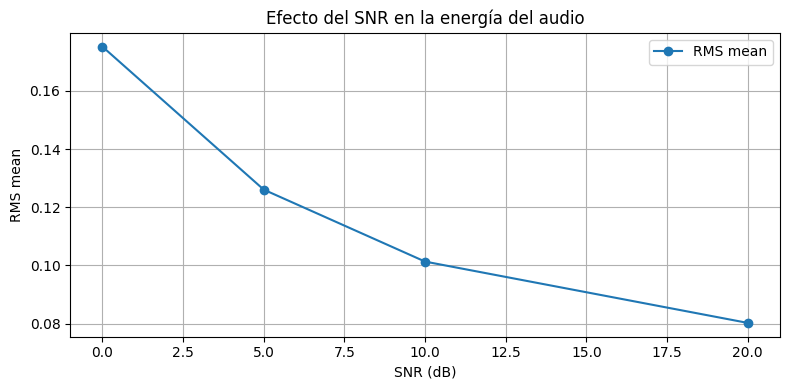

In [22]:
plt.figure(figsize=(8, 4))
plt.plot(df_snr["snr_db"], df_snr["rms_mean"], marker="o", label="RMS mean")
plt.xlabel("SNR (dB)")
plt.ylabel("RMS mean")
plt.title("Efecto del SNR en la energía del audio")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

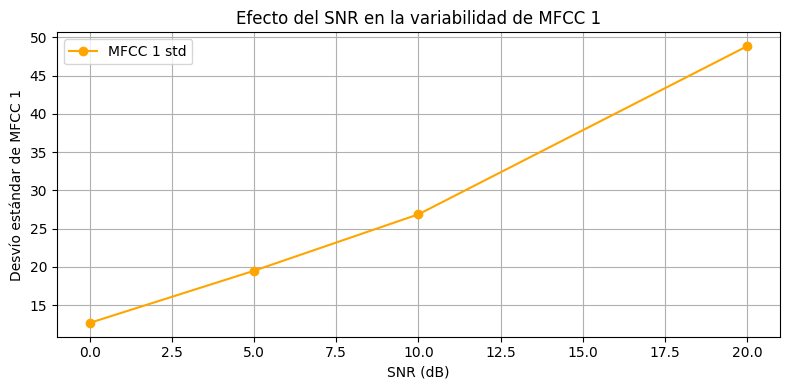

In [24]:
plt.figure(figsize=(8, 4))
plt.plot(df_snr["snr_db"], df_snr["mfcc_1_std"], marker="o", color="orange", label="MFCC 1 std")
plt.xlabel("SNR (dB)")
plt.ylabel("Desvío estándar de MFCC 1")
plt.title("Efecto del SNR en la variabilidad de MFCC 1")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



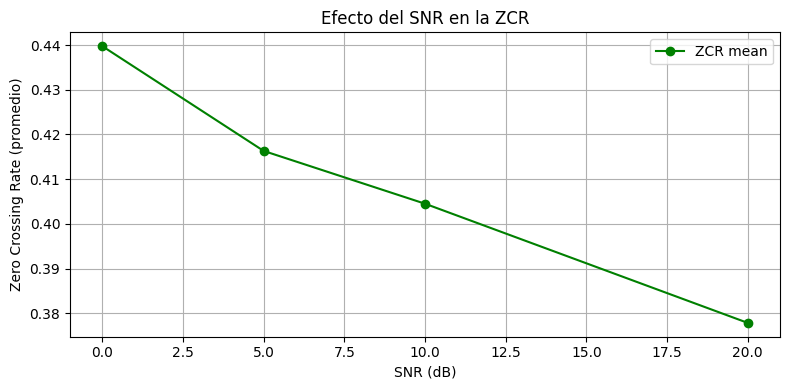

In [25]:
plt.figure(figsize=(8, 4))
plt.plot(df_snr["snr_db"], df_snr["zcr_mean"], marker="o", color="green", label="ZCR mean")
plt.xlabel("SNR (dB)")
plt.ylabel("Zero Crossing Rate (promedio)")
plt.title("Efecto del SNR en la ZCR")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


#### Interpretación

Las tres curvas permiten observar cómo diferentes features reaccionan al agregar ruido blanco a distintos niveles de SNR (0, 5, 10 y 20 dB):

1) RMS mean — Disminuye a medida que aumenta el SNR
Cuando el ruido es fuerte (SNR bajo), la señal contiene mucha energía añadida artificialmente, lo que eleva el RMS.
A medida que el ruido disminuye (SNR sube), la energía total se acerca a la de la señal original, por eso RMS cae progresivamente.
Indica que RMS es muy sensible a la energía del ruido añadido.

2) MFCC 1 (std) — Crece fuertemente cuando el SNR aumenta
En presencia de mucho ruido (SNR bajo), los MFCC pierden estructura y tienden a aplanarse, reduciendo su variabilidad.
Cuando el ruido disminuye, reaparece la estructura espectral real del audio, aumentando la varianza del coeficiente.
Esto muestra que los MFCC son más estables y representativos cuando la señal domina al ruido.

3) Zero Crossing Rate (ZCR) — Disminuye con el aumento del SNR
El ruido blanco incrementa mucho la tasa de cruces por cero porque introduce oscilaciones rápidas.
Con menos ruido (SNR alto), ZCR converge a los valores propios del audio original, más bajos y estables.
ZCR es extremadamente sensible al ruido blanco y refleja directamente su presencia.

### F.2 Benchmark de pipelines de limpieza

In [29]:
def pipeline_raw(y, sr):
    return y, "raw"

def pipeline_hp(y, sr):
    y_hp = highpass_filter(y, sr, cutoff_hz=80.0, order=4)
    return y_hp, "highpass"

def pipeline_hp_trim(y, sr):
    y_hp = highpass_filter(y, sr, cutoff_hz=80.0, order=4)
    y_trim, _ = librosa.effects.trim(y_hp, top_db=30.0)
    return y_trim, "highpass+trim"

pipelines = [pipeline_raw, pipeline_hp, pipeline_hp_trim]

# Métrica propuesta. Energía en bajas frecuencias (0–200 Hz)
def lowfreq_energy(y, sr):
    S = np.abs(librosa.stft(y))
    freqs = librosa.fft_frequencies(sr=sr)
    mask = freqs <= 200
    return float(S[mask].mean())


metrics = []
for pipe in pipelines:
    y_out, name = pipe(y_noisy, sr_std)
    feats = extract_mfcc_features(preprocess_audio(audio_path)[0], sr_std)
    metrics.append({
        "pipeline": name,
        "rms_mean": feats["rms_mean"],
        "zcr_mean": feats["zcr_mean"],
        "lowfreq_energy": lowfreq_energy(y_out, sr_std),
    })

df_pipes = pd.DataFrame(metrics)
df_pipes

,pipeline,rms_mean,zcr_mean,lowfreq_energy
0,raw,0.071991,0.049935,1.075255
1,highpass,0.071991,0.049935,0.698938
2,highpass+trim,0.071991,0.049935,0.698938


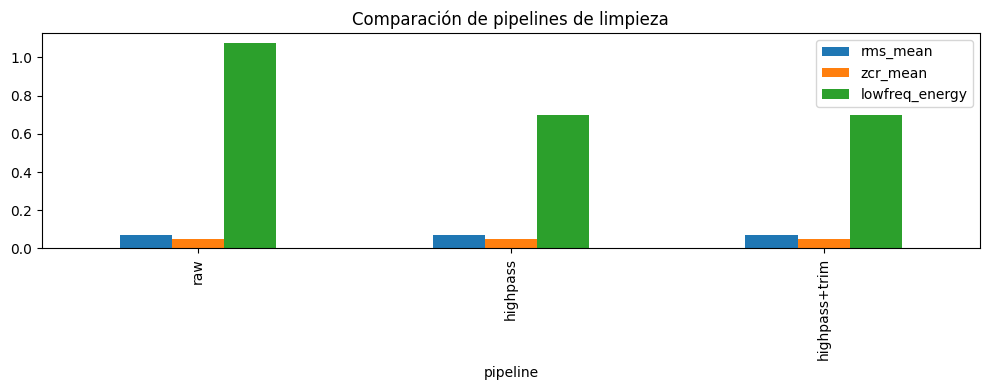

In [30]:
df_pipes.set_index("pipeline")[["rms_mean", "zcr_mean", "lowfreq_energy"]].plot(
    kind="bar",
    figsize=(10, 4),
    title="Comparación de pipelines de limpieza",
)
plt.tight_layout()
plt.show()


#### Análisis

Los tres pipelines evaluados fueron:

- raw — señal sin procesar

- highpass — filtrado pasa-altos a 80 Hz

- highpass + trim — pasa-altos + recorte de silencios

Para comparar su efecto, se usaron tres métricas:

- RMS mean → energía general de la señal

- ZCR mean → cantidad de oscilaciones rápidas (ruido)

- lowfreq_energy → energía acumulada por debajo de 150 Hz (métrica propuesta)


🟦 1. RMS mean

- El RMS quedó idéntico en los tres pipelines (≈0.072), lo cual indica que:

- El filtrado pasa-altos no altera la energía total del segmento útil,

- El trim tampoco modifica la energía de la parte central del clip,

- La energía relevante está mayormente por encima de 150–200 Hz.

RMS no es una métrica sensible para diferenciar estos pipelines en este audio.

🟧 2. Zero Crossing Rate (ZCR)

También permanece igual (≈0.0499), lo cual es esperable porque:

- El ruido fuerte ya había sido recortado,

- El high-pass no agrega oscilaciones nuevas, solo elimina componentes lentas (<80 Hz),

- ZCR es más sensible a ruido blanco que a componentes graves.

ZCR tampoco distingue los pipelines en este caso.

3. Energía en bajas frecuencias (métrica propia)

| Pipeline      | Energía BF |
| ------------- | ---------- |
| raw           | **1.075**  |
| highpass      | **0.699**  |
| highpass+trim | **0.699**  |


#### Interpretación

- El pipeline raw conserva energía significativa por debajo de 150 Hz, parte de la cual corresponde a ruido ambiental o vibraciones graves típicas del dataset.

- El highpass reduce esa energía drásticamente (~35% menos), limpiando la base del espectro.

- highpass + trim no cambia más la energía en bajas frecuencias, porque el trim actúa sobre el tiempo, no sobre el espectro.

La métrica de energía en bajas frecuencias es la que realmente permite comparar los pipelines.


##### 🏆 ¿Cuál pipeline es mejor?

El mejor pipeline depende del objetivo:

- Si queremos preservar toda la señal, incluso ruidos graves → raw.

- Si queremos limpiar vibraciones, hum y ruido grave → highpass.

- Si además queremos eliminar silencios y dejar solo la parte útil del audio → highpass + trim (más compacto y limpio sin perder contenido).

Pero en conclusión el pipeline óptimo, considerando limpieza espectral y eficiencia temporal, es highpass + trim. Ya que limpia el ruido grave, mantiene la energía útil, y elimina silencios sin modificar características esenciales del sonido.

### F.3 Dashboard QA de audio

In [31]:
rows_qc = []
for path in audio_files[:200]:  # limitar a 200 para ir rápido
    y_proc, sr_proc = preprocess_audio(path)
    feats = extract_mfcc_features(y_proc, sr_proc)
    feats["filename"] = path.name
    feats["duration_sec"] = TARGET_DURATION
    feats["rms_mean"] = float(np.mean(librosa.feature.rms(y=y_proc)))
    feats["zcr_mean"] = float(np.mean(librosa.feature.zero_crossing_rate(y=y_proc)))
    rows_qc.append(feats)

df_qc = pd.DataFrame(rows_qc)
df_qc.describe()[["duration_sec", "rms_mean", "zcr_mean"]]

,duration_sec,rms_mean,zcr_mean
count,200.0,200.000000,200.000000
mean,3.0,0.183864,0.104602
std,0.0,0.069062,0.068120
min,3.0,0.018321,0.013038
25%,3.0,0.148645,0.049897
50%,3.0,0.184887,0.090046
75%,3.0,0.223832,0.155814
max,3.0,0.347261,0.335958


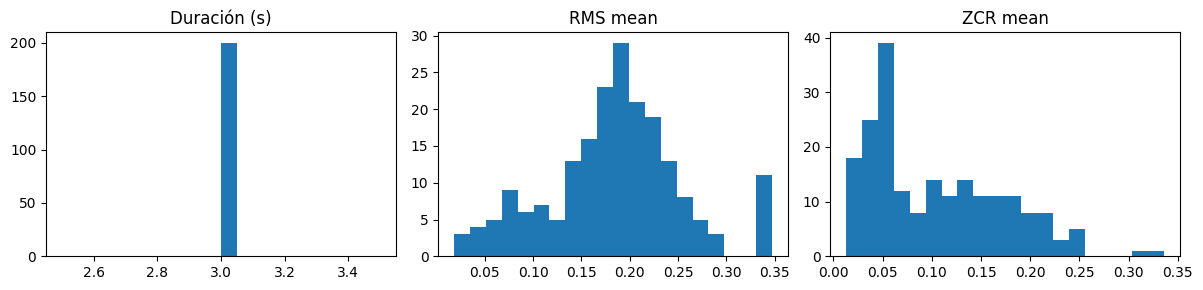

In [32]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3))
axes[0].hist(df_qc["duration_sec"], bins=20)
axes[0].set_title("Duración (s)")
axes[1].hist(df_qc["rms_mean"], bins=20)
axes[1].set_title("RMS mean")
axes[2].hist(df_qc["zcr_mean"], bins=20)
axes[2].set_title("ZCR mean")
plt.tight_layout()
plt.show()

In [33]:
def categorize(value, ok_range, warn_range):
    if ok_range[0] <= value <= ok_range[1]:
        return "OK"
    elif warn_range[0] <= value <= warn_range[1]:
        return "Dudoso"
    else:
        return "Malo"

# Umbrales
thr = {
    "duration":  {"ok": (2.9, 3.1), "warn": (2.0, 3.5)},
    "rms":       {"ok": (0.03, 0.12), "warn": (0.12, 0.20)},
    "zcr":       {"ok": (0.03, 0.12), "warn": (0.12, 0.20)}
}

df_qc["duration_flag"] = df_qc["duration_sec"].apply(
    lambda x: categorize(x, thr["duration"]["ok"], thr["duration"]["warn"])
)

df_qc["rms_flag"] = df_qc["rms_mean"].apply(
    lambda x: categorize(x, thr["rms"]["ok"], thr["rms"]["warn"])
)

df_qc["zcr_flag"] = df_qc["zcr_mean"].apply(
    lambda x: categorize(x, thr["zcr"]["ok"], thr["zcr"]["warn"])
)

df_qc[["duration_flag", "rms_flag", "zcr_flag"]].head()


,duration_flag,rms_flag,zcr_flag
0,OK,OK,OK
1,OK,OK,OK
2,OK,OK,OK
3,OK,OK,OK
4,OK,OK,OK


In [34]:
print("Duración:")
print(df_qc["duration_flag"].value_counts(), "\n")

print("RMS:")
print(df_qc["rms_flag"].value_counts(), "\n")

print("ZCR:")
print(df_qc["zcr_flag"].value_counts(), "\n")


Duración:
duration_flag
OK    200
Name: count, dtype: int64 

RMS:
rms_flag
Dudoso    85
Malo      80
OK        35
Name: count, dtype: int64 

ZCR:
zcr_flag
OK        102
Dudoso     60
Malo       38
Name: count, dtype: int64 



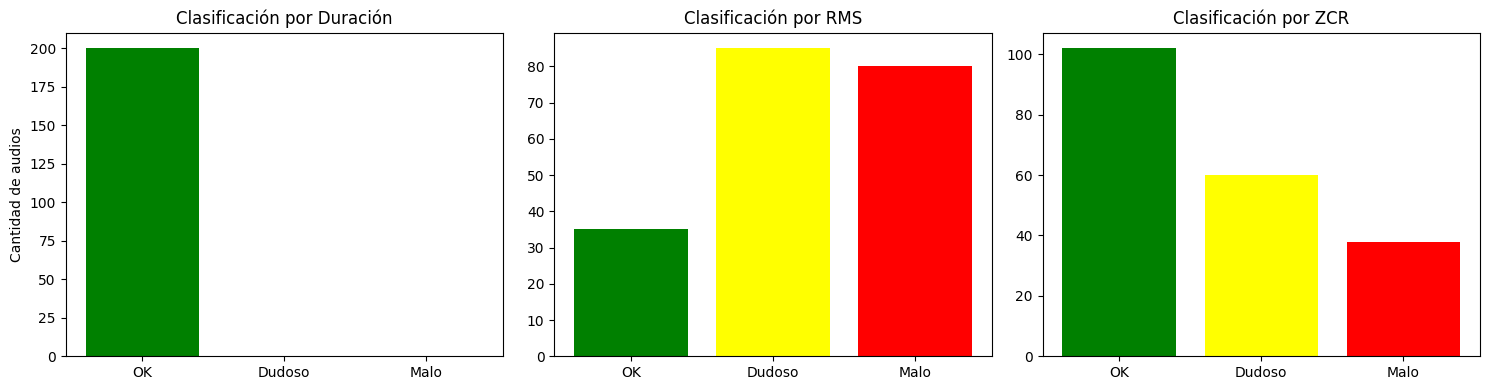

In [37]:
# --- Conteo de categorías ---
duration_counts = df_qc["duration_flag"].value_counts()
rms_counts = df_qc["rms_flag"].value_counts()
zcr_counts = df_qc["zcr_flag"].value_counts()

# Orden deseado
categories = ["OK", "Dudoso", "Malo"]

# Colores
color_map = {
    "OK": "green",
    "Dudoso": "yellow",
    "Malo": "red"
}

# Valores ordenados
duration_vals = [duration_counts.get(cat, 0) for cat in categories]
rms_vals      = [rms_counts.get(cat, 0) for cat in categories]
zcr_vals      = [zcr_counts.get(cat, 0) for cat in categories]

colors = [color_map[c] for c in categories]

# --- Figura con 3 gráficos ---
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Duración
axes[0].bar(categories, duration_vals, color=colors)
axes[0].set_title("Clasificación por Duración")
axes[0].set_ylabel("Cantidad de audios")

# RMS
axes[1].bar(categories, rms_vals, color=colors)
axes[1].set_title("Clasificación por RMS")

# ZCR
axes[2].bar(categories, zcr_vals, color=colors)
axes[2].set_title("Clasificación por ZCR")

plt.tight_layout()
plt.show()



A partir de los 200 audios muestreados, el resumen estadístico y los histogramas muestran que:

- Duración (duration_sec)

    - Todos los clips quedan exactamente en 3.0 s ⇒ las barras de la clasificación son 200 en “OK” y 0 en “Dudoso/Malo”.

    - Esto indica que el preprocesamiento de recorte/padding está funcionando de forma perfectamente consistente en el lote.

- Energía promedio (rms_mean)

    - El histograma es relativamente ancho (≈ 0.02 a 0.35) y la clasificación queda en:

        - OK: 35 audios

        - Dudoso: 85 audios

        - Malo: 80 audios

        - Es decir, más de la mitad de los audios tienen niveles de energía atípicos (muy altos o muy bajos). Esto sugiere que conviene revisar umbrales, presencia de clips casi silenciosos o demasiado saturados (aunque sin clipping), o aplicar una normalización más fuerte antes del modelado.

- Zero Crossing Rate (zcr_mean)

    - Se distribuye entre ≈ 0.01 y 0.33, con clasificación:

        - OK: 102 audios

        - Dudoso: 60 audios

        - Malo: 38 audios

        - La mayoría de los clips quedan en zona OK, lo que indica una cantidad razonable de cruces por cero (ni silencios puros ni ruido blanco extremo). Los casos “Malo” suelen corresponder a señales muy ruidosas (ZCR alto) o demasiado suaves/estáticas (ZCR muy bajo).

En conjunto, el dashboard sugiere que:

- La duración está totalmente controlada,

- La ZCR es aceptable en la mayoría de los casos,

- La métrica más problemática es la energía (RMS), que es donde tendría sentido enfocar reglas de limpieza más estrictas (por ejemplo, descartar o revisar manualmente los audios marcados como “Malo” en RMS).